Net GHG/Revenue Impact of Load-Shifting Batteries

In [1]:
import os, sys
PWD = os.getenv('PWD')
os.chdir(PWD)
sys.path.insert(0, os.getenv('PWD'))
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "local_settings.py")
import django
django.setup()

In [2]:
from datetime import date, datetime, timedelta
import pandas as pd

from beo_datastore.libs.battery import Battery, FixedScheduleBatterySimulation
from beo_datastore.libs.battery_schedule import create_fixed_schedule
from beo_datastore.libs.controller import (
    AggregateBatterySimulation, AggregateBillCalculator, AggregateGHGCalculator
)
from beo_datastore.libs.clustering import KMeansLoadClustering
from beo_datastore.libs.intervalframe import ValidationFrame288
from beo_datastore.libs.plot_intervalframe import (
        plot_frame288, plot_frame288_monthly_comparison, plot_intervalframe, plot_many_frame288s
)

from cost.ghg.models import GHGRate
from cost.utility_rate.models import RatePlan
from load.customer.models import Meter

In [3]:
# Configure Clustering
meters = Meter.objects.all()
normalize = False
number_of_clusters = 2
# choices are "average_frame288", "minimum_frame288", "maximum_frame288", "total_frame288", "count_frame288"
frame288_type = "total_frame288"

# run K-Means clustering algorithm
load_clustering = KMeansLoadClustering(
    objects=meters,
    frame288_type=frame288_type,
    number_of_clusters=number_of_clusters,
    normalize=normalize
)

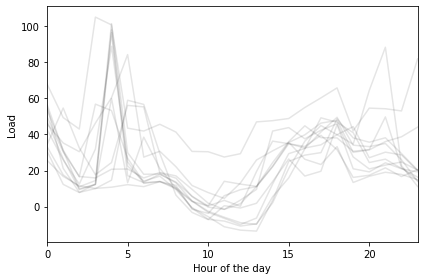

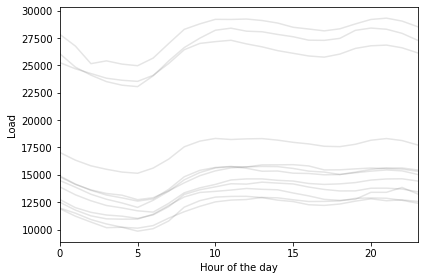

In [4]:
# plot each cluster's generic reference load

for i in sorted(set(load_clustering.cluster_labels)):
    plot_frame288(load_clustering.get_reference_frame288_by_cluster_id(i))

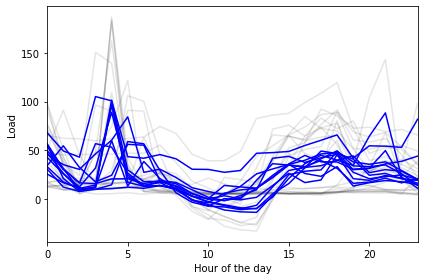

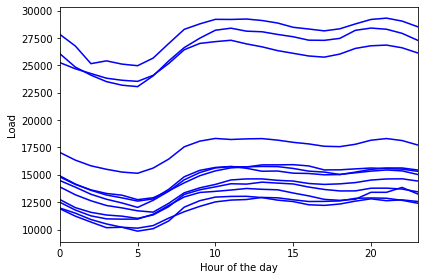

In [5]:
# plot matching load clusters against reference load

for i in sorted(set(load_clustering.cluster_labels)):
    plot_many_frame288s(
        load_clustering.get_cluster_frame288s_by_cluster_id(i),
        load_clustering.get_reference_frame288_by_cluster_id(i)
    )

In [6]:
# Choose a Cluster
meter_set = load_clustering.get_objects_by_cluster_id(0)
len(meter_set)

2

In [7]:
# only charge on NEM exports
charge_schedule = create_fixed_schedule(0, 0, 0, 0)
# always discharge between 4 p.m. and 9 p.m.
discharge_schedule = create_fixed_schedule(16, 22, 0, float("inf"))

display(charge_schedule.dataframe)
display(discharge_schedule.dataframe)

,1,2,3,4,5,6,7,8,9,10,11,12
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0


,1,2,3,4,5,6,7,8,9,10,11,12
0,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
1,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
3,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
4,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
5,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
6,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
7,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
8,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
9,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [8]:
# run battery simulation

battery = Battery(rating=5, discharge_duration=timedelta(hours=2), efficiency=0.9)

simulation = AggregateBatterySimulation.create(
    battery=battery,
    start=datetime(2018, 1, 1),
    end_limit=datetime(2019, 1, 1),
    meter_set=meter_set,
    charge_schedule=charge_schedule,
    discharge_schedule=discharge_schedule,
    multiprocess=True,
)

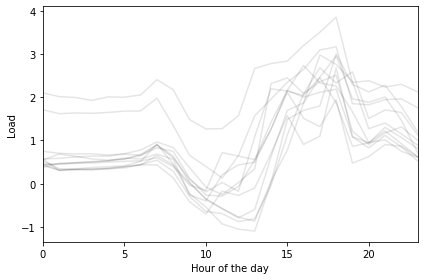

None

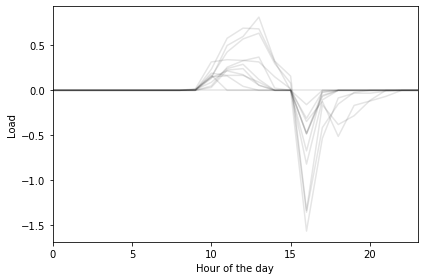

None

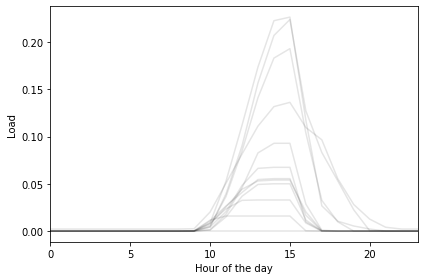

None

In [9]:
# examine individual battery operations
battery_simulation = list(simulation.battery_simulations)[0]
battery_intervalframe = battery_simulation.battery_intervalframe

# average daily load
display(plot_frame288(battery_simulation.load_intervalframe.average_frame288))

# average battery discharge
battery_intervalframe.aggregation_column = "kw"
display(plot_frame288(battery_intervalframe.average_frame288))

# average battery state of charge
battery_intervalframe.aggregation_column = "charge"
charge_frame288 = battery_intervalframe.average_frame288
battery_intervalframe.aggregation_column = "capacity"
capacity_frame288 = battery_intervalframe.average_frame288
display(plot_frame288(charge_frame288/capacity_frame288))

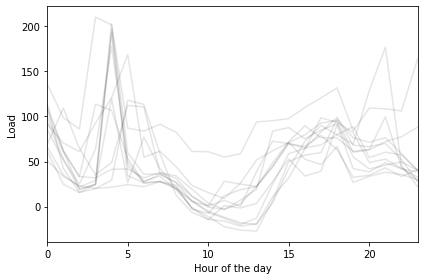

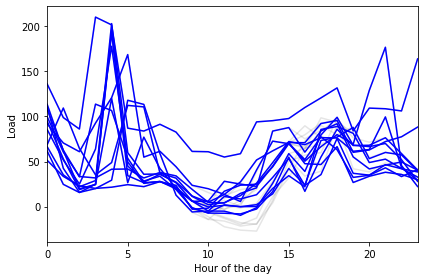

In [10]:
# plot aggregate intervalframes
frame288_type = "total_frame288"

plot_frame288(simulation.aggregate_pre_intervalframe.total_frame288)
plot_many_frame288s(
    [getattr(simulation.aggregate_pre_intervalframe, frame288_type)],
    getattr(simulation.aggregate_post_intervalframe, frame288_type),
)

In [11]:
# PG&E Grid Averages GHG Impact
# "435 pounds of CO2 per megawatt hour (MWh)"
# Source: https://www.pge.com/en_US/about-pge/environment/what-we-are-doing/fighting-climate-change/fighting-climate-change.page
pge_co2 = ValidationFrame288.convert_matrix_to_frame288([[0.000435] * 24] * 12)
ghg = AggregateGHGCalculator(
    simulation=simulation,
    ghg_frame288=pge_co2
)
display(ghg.comparison_table)

,before,after
1,1.102418,1.102418
2,0.719085,0.719531
3,0.570100,0.571038
4,0.460788,0.461592
5,0.458501,0.458741
6,0.416623,0.418591
7,0.444656,0.448049
8,0.436140,0.439076
9,0.415392,0.418698
10,0.470789,0.472181


In [12]:
# Clean Net Short GHG Impact
for year in [2018, 2022, 2026, 2030]:
    ghg_rate = GHGRate.objects.get(name="Clean Net Short", effective__year=year).frame288
    ghg = AggregateGHGCalculator(
        simulation=simulation,
        ghg_frame288=pge_co2
    )
    display(ghg.comparison_table)

,before,after
1,1.102418,1.102418
2,0.719085,0.719531
3,0.570100,0.571038
4,0.460788,0.461592
5,0.458501,0.458741
6,0.416623,0.418591
7,0.444656,0.448049
8,0.436140,0.439076
9,0.415392,0.418698
10,0.470789,0.472181


,before,after
1,1.102418,1.102418
2,0.719085,0.719531
3,0.570100,0.571038
4,0.460788,0.461592
5,0.458501,0.458741
6,0.416623,0.418591
7,0.444656,0.448049
8,0.436140,0.439076
9,0.415392,0.418698
10,0.470789,0.472181


,before,after
1,1.102418,1.102418
2,0.719085,0.719531
3,0.570100,0.571038
4,0.460788,0.461592
5,0.458501,0.458741
6,0.416623,0.418591
7,0.444656,0.448049
8,0.436140,0.439076
9,0.415392,0.418698
10,0.470789,0.472181


,before,after
1,1.102418,1.102418
2,0.719085,0.719531
3,0.570100,0.571038
4,0.460788,0.461592
5,0.458501,0.458741
6,0.416623,0.418591
7,0.444656,0.448049
8,0.436140,0.439076
9,0.415392,0.418698
10,0.470789,0.472181


In [13]:
# create date ranges used in billing
date_ranges = [(date(2018, x, 1), date(2018, x + 1, 1)) for x in range(1, 12)]
date_ranges.append((date(2018, 12, 1), date(2019, 1, 1)))

# Choose meters and rate plan
rate_plan = RatePlan.objects.first()

# Calculate bills
bills = AggregateBillCalculator(
    simulation=simulation,
    date_ranges=date_ranges,
    rate_plan=rate_plan,
    multiprocess=True,
)

# aggregate bill differences
print("before: ", bills.pre_DER_bill_grand_total, " after: ", bills.post_DER_bill_grand_total)

before:  3233.904672768333  after:  3247.495636105


In [14]:
display(bills.before_bills[0][date(2018, 7, 1)].total_dataframe)
display(bills.after_bills[0][date(2018, 7, 1)].total_dataframe)

,category,description,tou_period,count,count_unit,rate,rate_unit,pro_rata,total
0,energy,Energy Charge (7.5 max kWh/day),0,232.500,kWh,0.1323,$/kWh,1,30.759750
1,energy,Energy Charge (9.75 max kWh/day),0,69.750,kWh,0.1504,$/kWh,1,10.490400
2,energy,Energy Charge (15 max kWh/day),0,162.750,kWh,0.32377,$/kWh,1,52.693568
3,energy,Energy Charge (22.5 max kWh/day),0,61.907,kWh,0.36377,$/kWh,1,22.519909
Total,,,,526.907,,,,,116.463627


,category,description,tou_period,count,count_unit,rate,rate_unit,pro_rata,total
0,energy,Energy Charge (7.5 max kWh/day),0,232.500,kWh,0.1323,$/kWh,1,30.759750
1,energy,Energy Charge (9.75 max kWh/day),0,69.750,kWh,0.1504,$/kWh,1,10.490400
2,energy,Energy Charge (15 max kWh/day),0,162.750,kWh,0.32377,$/kWh,1,52.693568
3,energy,Energy Charge (22.5 max kWh/day),0,69.707,kWh,0.36377,$/kWh,1,25.357315
Total,,,,534.707,,,,,119.301033
